<a href="https://colab.research.google.com/github/DanaJian/Machine-learning-technologies/blob/main/%D0%A1lustering_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import torch
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import random_split
from torchvision import datasets, transforms
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

1. ПОДГОТОВКА ДАННЫХ

In [90]:
# Преобразование изображений в тензор и нормализация
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,1307,),(0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=tf)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=tf)

# Преобразование в массивы типа np.ndarray
X_train = train_dataset.data[:len(train_dataset)//50].numpy().reshape(-1, 28*28)
y_train = train_dataset.targets[:len(train_dataset)//50].numpy()

In [91]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0, 1307), std=(0.3081,))
           )

In [92]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0, 1307), std=(0.3081,))
           )

2. РЕАЛИЗАЦИЯ ФУНКЦИЙ АЛГОРИТМОВ K-MEANS И ИЕРАРХИЧЕСКОЙ КЛАСТЕРИЗАЦИИ

In [93]:
def kmeans(X, k, max_iter=100) -> tuple[np.ndarray, np.ndarray]:
    centers = X[np.random.choice(X.shape[0], k, replace=False)]
    
    for i in range(max_iter):
        distances = np.sqrt(((X - centers[:, np.newaxis])**2).sum(axis=2))
        labels = distances.argmin(axis=0)
        new_centers = np.array([X[labels == j].mean(axis=0) for j in range(k)])
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    return centers, labels


def hierarchical_clustering(X, method='ward', metric='euclidean') -> tuple[np.ndarray, np.ndarray]:
    distances = np.sqrt(((X[:, np.newaxis, :] - X[np.newaxis, :, :])**2).sum(axis=-1))

    linkage_matrix = linkage(distances, method=method, metric=metric)
    return linkage_matrix


def plot_dendrogram(linkage_matrix, **kwargs):
    dendrogram(linkage_matrix, **kwargs)

3. ПОЛУЧЕНИЕ МЕТОК

<ipython-input-93-480db4b10c3a>:17: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



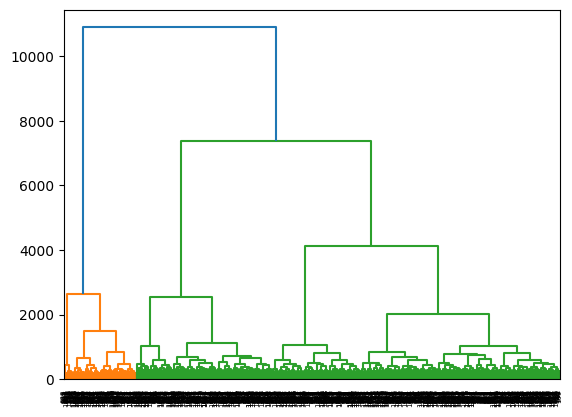

In [94]:
centers, kmean_labels = kmeans(X_train, k=10)

dist_matrix = squareform(pdist(X_train))
linkage_matrix = hierarchical_clustering(X_train)
hier_clust_labels = fcluster(linkage_matrix, 10, criterion=('maxclust'))
plot_dendrogram(linkage_matrix)

4. ПОСТРОЕНИЕ КРИВОЙ ЗАВИСИМОСТИ ИНТЕРКЛАСТЕРНОГО РАССТОЯНИЯ  ОТ ЧИСЛА КЛАСТЕРОВ ДЛЯ АЛГОРИТМА ИЕРАРХИЧЕСКОЙ КЛАСТЕРИЗАЦИИ

In [95]:
n_clusters = list(range(1, len(hier_clust_labels) + 1))  # список с числом кластеров
intercluster_distances = linkage_matrix[::-1, 2]  # список с интеркластерным расстоянием
scatter = go.Scatter(x=n_clusters, y=intercluster_distances, mode='lines')
fig = go.Figure(scatter)
fig.update_layout(
    xaxis_title='Число кластеров',
    yaxis_title='Интеркластерное расстояние',
    title='Зависимость интеркластерного расстояния от числа кластеров'
)
fig.show()

5. СРАВНЕНИЕ АЛГОРИТМОВ K-MEANS И ИЕРАРХИЧЕСКОЙ КЛАСТЕРИЗАЦИИ

In [96]:
X = kmean_labels
y = y_train

kmeans_data = {
  "Adjusted Rand Index": adjusted_rand_score(X, y),
  "Normalized Mutual Information": normalized_mutual_info_score(X, y)
}

df = pd.DataFrame(kmeans_data, index=['Значение'])
df

,Adjusted Rand Index,Normalized Mutual Information
Значение,0.32771,0.478174


In [97]:
X = hier_clust_labels
y = y_train

hier_data = {
  "Adjusted Rand Index": adjusted_rand_score(X, y),
  "Normalized Mutual Information": normalized_mutual_info_score(X, y)
}

df = pd.DataFrame(hier_data, index=['Значение'])
df

,Adjusted Rand Index,Normalized Mutual Information
Значение,0.103315,0.222243
